# New Section

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lcc-fasd:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F724551%2F1259264%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T144516Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D741e0826fbda4f60adc2c784b2b17ce6c402a9ad04bc567699eb9ee4e39aef773fe57404f3c35a41e1f0eafa7e1b59f812ccc1e1766a284fd78bc8712c518db5890bafe4b435beb696de2338f695f98829a28a119eae01717723bc51bdcab2caf28650fc29f6451fda28c0b23c447a60039fc85f26b8813e3cc48e845bdd9e92785af5a920e35ba14ece7cc8645936e280b7afb0410e2d4b20de6307878eca6b0f95f3573e3f70df98363014e57c4dc92ad41555c0a64e5160d80af81f5e98a156779d3fc913a170b0328f464b2dd3fc9f08b5d46ec999c0214d7bd6bd9fc20c51b13abfd56e2131bbe553af1a7980eff4df9405f932e800c2b537547e21788e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5196000412 bytes downloaded
Downloaded and uncompressed: lcc-fasd
Data source import complete.


# Install Necessary Packages

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 8.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Import Necessary Libraries

In [4]:
import os
import torch
import shutil
import cv2 as cv
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [5]:
os.makedirs('/kaggle/working/dataset', exist_ok=True)

In [6]:
shutil.copytree('/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training', '/kaggle/working/dataset/train')
shutil.copytree('/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation', '/kaggle/working/dataset/val')
shutil.copytree('/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_development', '/kaggle/working/dataset/test')

'/kaggle/working/dataset/test'

# Necessary Functions

In [7]:
def random_image_index(lenght_data: int) -> int:

    return np.random.randint(0, lenght_data-1)

In [8]:
def random_images(data_path: str) -> list:

    images_lst = []
    images_root = os.listdir(data_path)

    for i in range(16):
        index_image = random_image_index(len(images_root))
        image_path = os.path.join(data_path, images_root[index_image])
        images_lst.append(image_path)

    return images_lst

In [9]:
def show_images(data_path: str, label: str) -> None:
    images_lst = random_images(data_path)

    num_rows = 4
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for i, image_path in enumerate(images_lst):
        image = cv.imread(image_path)
        axes[i // num_cols, i % num_cols].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB), interpolation='none')
        axes[i // num_cols, i % num_cols].set_title(f"Image {label}")
        axes[i // num_cols, i % num_cols].axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
def count_samples_in_dataset(data_path: str, data_type: str) -> None:

    data_real = os.path.join(data_path, "real")
    data_spoof = os.path.join(data_path, "spoof")

    print(f"Data {data_type}: Image real: {len(os.listdir(data_real))} - Image spoof: {len(os.listdir(data_spoof))}")


# Visualization Dataset

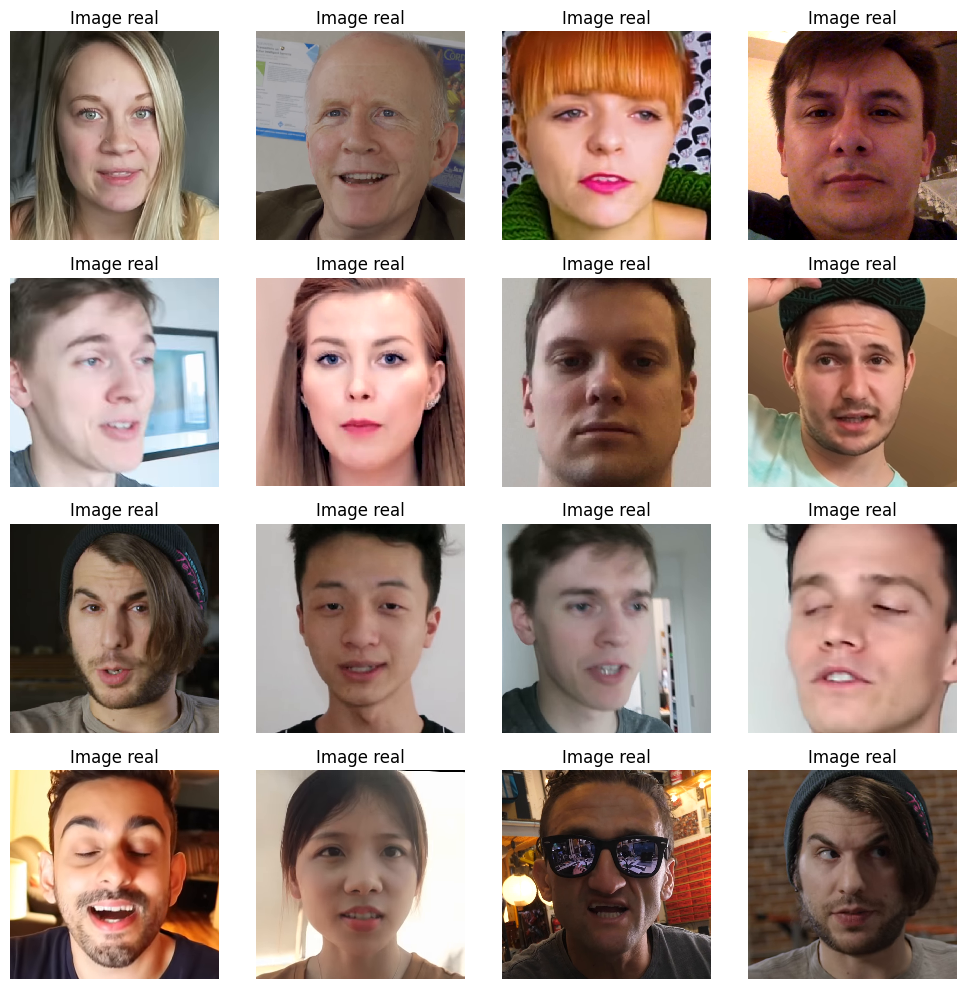

In [11]:
show_images('/kaggle/working/dataset/train/real', "real")

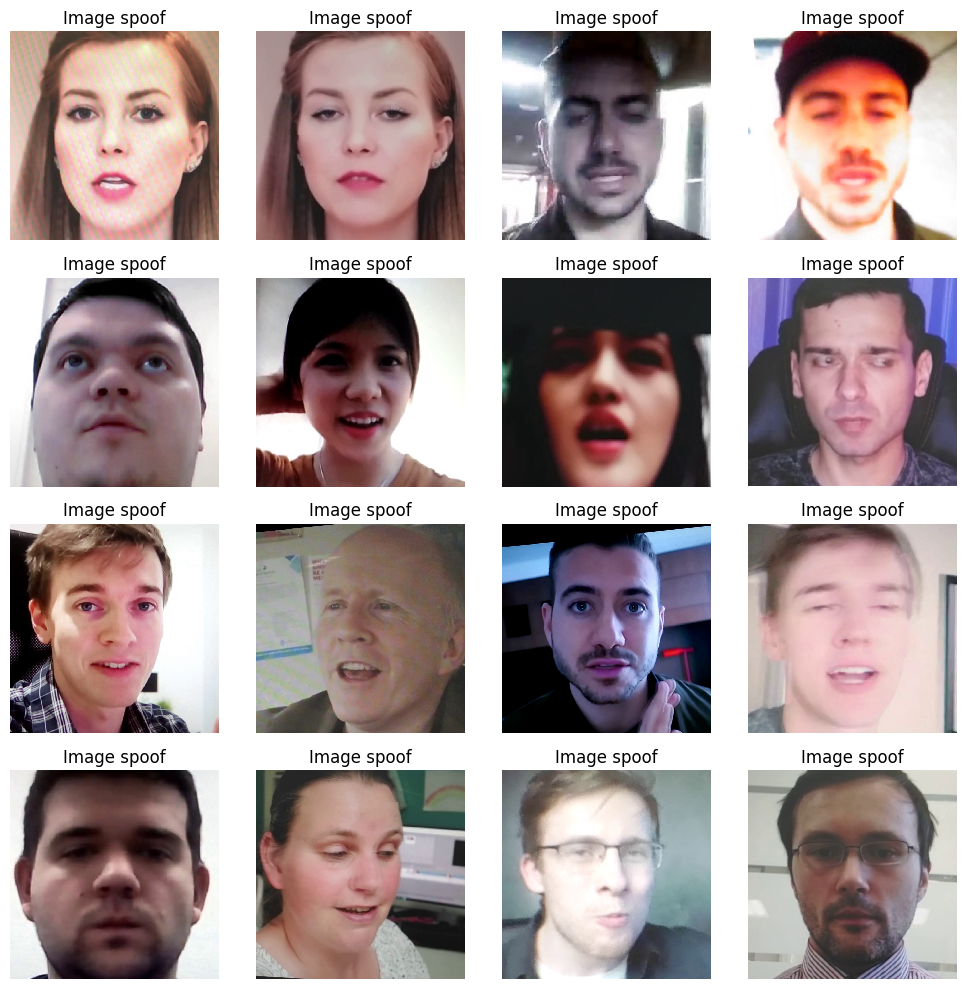

In [12]:
show_images('/kaggle/working/dataset/train/spoof', "spoof")

In [13]:
count_samples_in_dataset("/kaggle/working/dataset/val", "val")

Data val: Image real: 314 - Image spoof: 7266


In [14]:
count_samples_in_dataset("/kaggle/working/dataset/test", "test")

Data test: Image real: 405 - Image spoof: 2543


In [15]:
count_samples_in_dataset("/kaggle/working/dataset/train", "train")

Data train: Image real: 1223 - Image spoof: 7076


# Training Model Yolov8

In [16]:
model = YOLO(model='yolov8x-cls.pt')

100%|██████████| 110M/110M [00:00<00:00, 343MB/s] 


In [17]:
!wandb login 4a08b8210d1fda29a218a5dc7cf5be6b7e36f67f

/bin/bash: line 1: wandb: command not found


In [25]:
model.train(data='/kaggle/working/dataset', epochs=2, imgsz=640, device=[0])

Ultralytics YOLOv8.2.49 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8x-cls.pt, data=/kaggle/working/dataset, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /kaggle/working/dataset/train... 8299 images, 0 corrupt: 100%|██████████| 8299/8299 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/val... 7580 images, 0 corrupt: 100%|██████████| 7580/7580 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 2 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 237/237 [03:53<00:00,  1.01it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 237/237 [03:53<00:00,  1.01it/s]

                   all      0.965          1



2 epochs completed in 0.402 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 112.5MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 112.5MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics YOLOv8.2.49 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-cls summary (fused): 133 layers, 56125762 parameters, 0 gradients, 153.8 GFLOPs
train: /kaggle/working/dataset/train... found 8299 images in 2 classes ✅ 
val: /kaggle/working/dataset/val... found 7580 images in 2 classes ✅ 
test: /kaggle/working/dataset/test... found 2948 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 237/237 [03:51<00:00,  1.02it/s]


                   all      0.965          1
Speed: 0.6ms preprocess, 14.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a814e764b20>
curves: []
curves_results: []
fitness: 0.9822559356689453
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9645118713378906, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9822559356689453}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.6367242430634108, 'inference': 14.867572702644368, 'loss': 0.0012446519252807295, 'postprocess': 0.0005660082230781817}
task: 'classify'
top1: 0.9645118713378906
top5: 1.0

In [20]:
!pwd

/content


In [24]:
outs = model.predict("/content/real_101.png")
print(outs)



image 1/1 /content/real_101.png: 640x640 real 1.00, spoof 0.00, 61.9ms
Speed: 18.4ms preprocess, 61.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'real', 1: 'spoof'}
obb: None
orig_img: array([[[200, 198, 203],
        [200, 198, 203],
        [201, 199, 204],
        ...,
        [193, 188, 187],
        [195, 190, 189],
        [196, 191, 190]],

       [[201, 199, 204],
        [201, 199, 204],
        [201, 199, 204],
        ...,
        [189, 184, 183],
        [191, 186, 185],
        [193, 188, 187]],

       [[202, 200, 205],
        [202, 200, 205],
        [202, 200, 205],
        ...,
        [185, 180, 179],
        [187, 182, 181],
        [190, 185, 184]],

       ...,

       [[125, 144, 172],
        [126, 145, 173],
        [126, 145, 173],
        ...,
        [199, 194, 195],
        [199, 194, 195],
        [199, 194, 195]],

     

LOAD MODEL

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the YOLOv8 model with custom weights
model1 = YOLO("/content/drive/MyDrive/CV_project/1-Face_Anti_Spoofing_Using_Yolov8/classify/train/weights/best.pt")
model2 = YOLO("/content/drive/MyDrive/CV_project/1-Face_Anti_Spoofing_Using_Yolov8/classify/train2/weights/best.pt")


In [ ]:
# Define the image path
image_path = "/content/face.jpg"

# Run the prediction
results = model1.predict(source=image_path)
results2 = model2.predict(source=image_path)
# print(results.type)
# Extract the results
# boxes = results[0].boxes.xyxy.cpu().numpy()  # Get the bounding box coordinates
# confidences = results[0].boxes.conf.cpu().numpy()  # Get the confidence scores
# class_ids = results[0].boxes.cls.cpu().numpy()  # Get the class IDs

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw the bounding boxes
# for box, confidence, class_id in zip(boxes, confidences, class_ids):
#     x1, y1, x2, y2 = map(int, box)
#     label = f"Class {int(class_id)}: {confidence:.2f}"
#     cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
#     cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image with bounding boxes
plt.imshow(image)
plt.axis('off')
plt.show()


